In [61]:
# !pip install pytorch-tabnet
# !pip install torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import torch

# Reading Files

In [62]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
# df

# Model Fitting

### TabNet with All Features: Performance Evaluation and ROC Curve

In [63]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable
#TabNet should be used on numpy
X = X.to_numpy()
y = y.to_numpy()
# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
scoring = ['precision', 'accuracy', 'recall','f1']

In [65]:
# Initialize the feature scaler
scaler = StandardScaler()

# Standardize the training and testing sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the TabNet classifier
clf = TabNetClassifier(verbose=0)

# Define the hyperparameters to tune
param_grid = {
#     'n_d': [8, 16, 32],        # Dimension of decision prediction
#     'n_a': [8, 16, 32],        # Dimension of the attention embeddings
#     'n_steps': [3, 5, 7],      # Number of decision steps
#     'gamma': [1.0, 1.5, 2.0],  # Relaxation factor for the sparsity
    'lambda_sparse': [0.001,0.0005,0.0002,0.0003, 0.0001],  # Regularization coefficient
}

# Set up GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=20, verbose=1, n_jobs=-1, scoring='f1')

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best estimator after tuning
best_clf = grid_search.best_estimator_

# Predict on the test set
preds = best_clf.predict(X_test)
preds_proba = best_clf.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='binary')
recall = recall_score(y_test, preds, average='binary')
f1 = f1_score(y_test, preds, average='binary')

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 20 folds for each of 5 candidates, totalling 100 fits


C:\Users\15982\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Best Parameters: {'lambda_sparse': 0.0003}
Accuracy: 0.8776
Precision: 0.8261
Recall: 0.6387
F1 Score: 0.7204


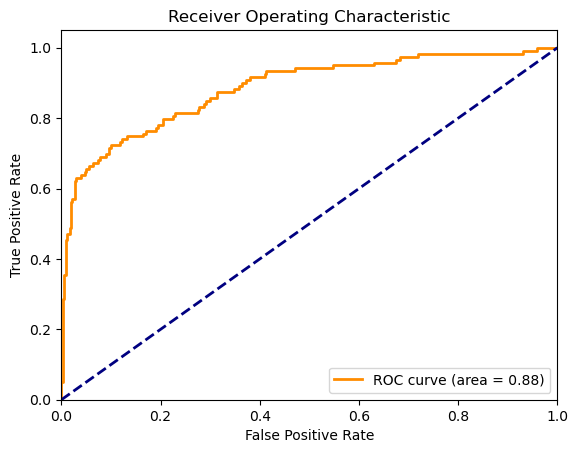

In [66]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The model demonstrates strong accuracy, f1 score and precision, which implies good performance in predicting positive cases. However, the recall is comparatively low, indicating that the model struggles to effectively identify all positive cases (i.e., patients with cardiovascular diseases), potentially overlooking a substantial number of positive instances.

### TabNet with Selected Features ( feature_importances > 0.05): Performance Evaluation and ROC Curve

In [67]:
significant_vars = df.drop('Cardiovascular', axis=1).columns
X = df.drop('Cardiovascular', axis=1).values
y = df['Cardiovascular'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tabnet_clf = TabNetClassifier(verbose=0)

tabnet_clf.fit(X_train, y_train, max_epochs=100, patience=10, batch_size=1024, virtual_batch_size=128)

#get the importance of every feature
feature_importances = tabnet_clf.feature_importances_

for i, var in enumerate(significant_vars):
    print(f"Feature: {var}, Importance: {feature_importances[i]}")

#filter the features with an importance greater than threshold
threshold = 0.05
significant_features = [significant_vars[i] for i in range(len(feature_importances)) if feature_importances[i] > threshold]

C:\Users\15982\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Feature: LOS, Importance: 0.13938096757316137
Feature: ICU_ADMIN_FLAG, Importance: 0.0033025030734051075
Feature: HEIGHT, Importance: 0.017596596940530906
Feature: WEIGHT, Importance: 0.002491154951689862
Feature: SEX, Importance: 3.969070525624504e-05
Feature: ASA_RATING_C, Importance: 0.07138522810066426
Feature: Abnormal Flag, Importance: 0.003874710040429684
Feature: ORDER_STATUS_IMPACT, Importance: 0.0022291706592969785
Feature: discharge_risk_level, Importance: 0.0008728371344441112
Feature: BIRTH_DATE, Importance: 0.03498609993497909
Feature: PATIENT_CLASS_GROUP, Importance: 0.015442783230943741
Feature: PATIENT_CLASS_NM, Importance: 0.020927220445938435
Feature: systolic_peak, Importance: 0.030048424869012696
Feature: diastolic_peak, Importance: 0.005308129157197314
Feature: pulse_amplitude, Importance: 0.0005170980299809747
Feature: arc_peak_frequency, Importance: 0.004194546342111652
Feature: arc_spectral_energy, Importance: 0.010131787563695463
Feature: arc_bandwidth, Import

In [68]:
#the name of significant features
print(f"Selected significant features: {significant_features}")

Selected significant features: ['LOS', 'ASA_RATING_C', 'arc_bandwidth', 'vf_freq_power', 'Calcium', 'Erythrocyte distribution width']


Fitting 20 folds for each of 5 candidates, totalling 100 fits


C:\Users\15982\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Best Parameters: {'lambda_sparse': 0.001}
Accuracy: 0.8859
Precision: 0.8478
Recall: 0.6555
F1 Score: 0.7393


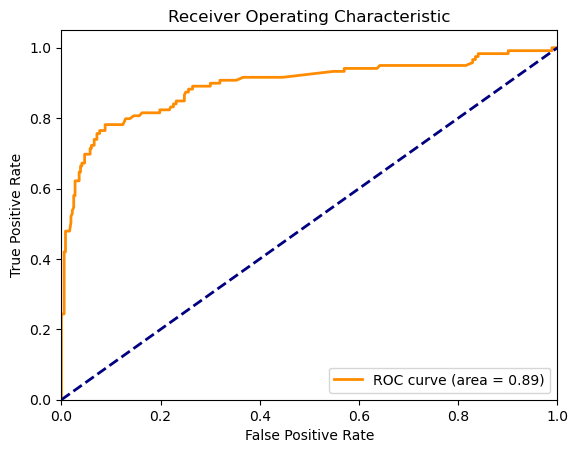

In [69]:
X = df[significant_features].values
y = df['Cardiovascular'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the feature scaler
scaler = StandardScaler()

# Standardize the training and testing sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the TabNet classifier
clf = TabNetClassifier(verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'lambda_sparse': [0.001, 0.0005, 0.0002, 0.0003, 0.0001],  # Regularization coefficient
}

# Set up GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=20, verbose=1, n_jobs=-1, scoring='f1')

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best estimator after tuning
best_clf = grid_search.best_estimator_

# Predict on the test set
preds = best_clf.predict(X_test)
preds_proba = best_clf.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='binary')
recall = recall_score(y_test, preds, average='binary')
f1 = f1_score(y_test, preds, average='binary')

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The recall increased from 0.639 to 0.656 after filtering variables with feature_importance>0.05, indicating that the model now captures more true positive cases.

#### Handling Imbalanced Data using SMOTE in TabNet

In [70]:
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable
print(y.value_counts())

0.0    1206
1.0     398
Name: Cardiovascular, dtype: int64


The output reveals an imbalance in the y data, with 1206 samples labeled as 0.0 and only 398 labeled as 1.0.  This significant difference in sample size between the categories can lead to the model becoming biased towards predicting the more frequent category during training.

Fitting 20 folds for each of 5 candidates, totalling 100 fits


C:\Users\15982\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Best Parameters: {'lambda_sparse': 0.0001}
Accuracy: 0.8465
Precision: 0.6510
Recall: 0.8151
F1 Score: 0.7239


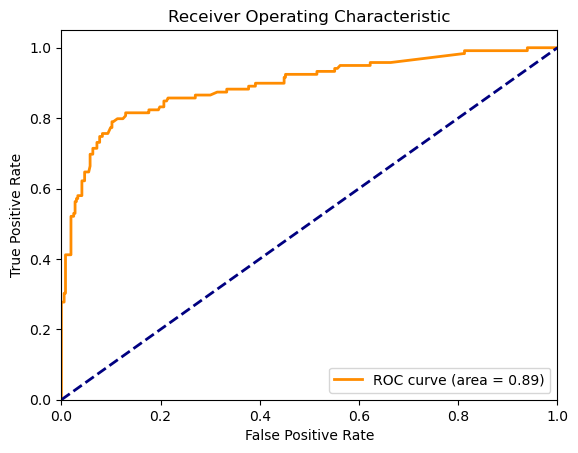

In [73]:
X = df[significant_features].values
y = df['Cardiovascular'].values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize the feature scaler
scaler = StandardScaler()

# Standardize the training and testing sets
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# Initialize the TabNet classifier
clf = TabNetClassifier(verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'lambda_sparse': [0.001, 0.0005, 0.0002, 0.0003, 0.0001],  # Regularization coefficient
}

# Set up GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=20, verbose=1, n_jobs=-1, scoring='f1')
# Train the model with hyperparameter tuning
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator after tuning
best_clf = grid_search.best_estimator_

# Predict on the test set
preds = best_clf.predict(X_test)
preds_proba = best_clf.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='binary')
recall = recall_score(y_test, preds, average='binary')
f1 = f1_score(y_test, preds, average='binary')

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Applying SMOTE significantly boosted recall, though it slightly reduced precision, accuracy, and F1 score. This adjustment improved the model's ability to detect the minority class. Since recall is the primary evaluation metric in this experiment, the use of SMOTE successfully optimized the model.